In [1]:
!nvidia-smi
import multiprocessing

Tue Apr 22 18:38:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE = 256
EPOCHS = 20
NUM_CLASSES = 7
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BASE_PATH = '/content/drive/MyDrive/FER_Sentiment_Analysis'
TRAIN_PATH = os.path.join(BASE_PATH, 'train')
TEST_PATH = os.path.join(BASE_PATH, 'test')

In [5]:
EMOTION_LABELS = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [6]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 10 * 10, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

In [7]:
print(f"Using device: {DEVICE}")
print(f"Training data path: {TRAIN_PATH}")
print(f"Testing data path: {TEST_PATH}")

train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=train_transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_transform
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


Using device: cuda
Training data path: /content/drive/MyDrive/FER_Sentiment_Analysis/train
Testing data path: /content/drive/MyDrive/FER_Sentiment_Analysis/test
Number of training samples: 28709
Number of testing samples: 7178


In [8]:
def train(model, device, train_loader, optimizer):

    model.train()

    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_idx, (input, target) in enumerate(train_loader):
        input = input.to(DEVICE)
        target = target.type(torch.LongTensor).to(DEVICE)

        optimizer.zero_grad()
        output = model(input)

        loss = nn.CrossEntropyLoss()
        loss_value = loss(output, target)

        loss_value.backward()
        optimizer.step()

        train_loss += loss_value
        train_correct += torch.sum(torch.argmax(output, dim=1) == target)
        train_total += input.shape[0]

    avg_loss = train_loss.item() / len(test_loader)
    accuracy = (train_correct / train_total).item()

    return avg_loss, accuracy

In [9]:
def test(model, device, test_loader, optimizer):
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(test_loader):
            input = input.to(DEVICE)
            target = target.type(torch.LongTensor).to(DEVICE)

            output = model(input)
            predictions = torch.argmax(output, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            loss = nn.CrossEntropyLoss()
            loss_value = loss(output, target)

            test_loss += loss_value.item()
            test_correct += torch.sum(torch.argmax(output, dim=1) == target).item()
            test_total += input.shape[0]

    cm = confusion_matrix(all_targets, all_predictions)
    test_loss = test_loss / len(test_loader)
    accuracy = test_correct / test_total

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=EMOTION_LABELS.values(),
                yticklabels=EMOTION_LABELS.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return test_loss, accuracy

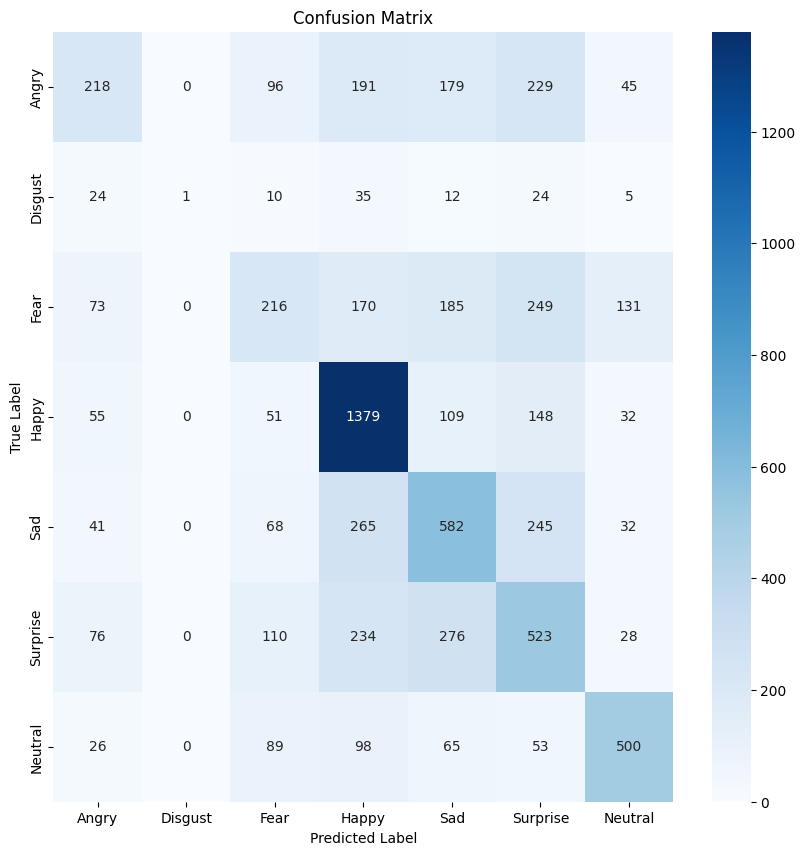

Epoch 1/20:
Train Loss: 6.3376 | Train Acc: 39.88%
Test Loss: 1.3581 | Test Acc: 47.63%


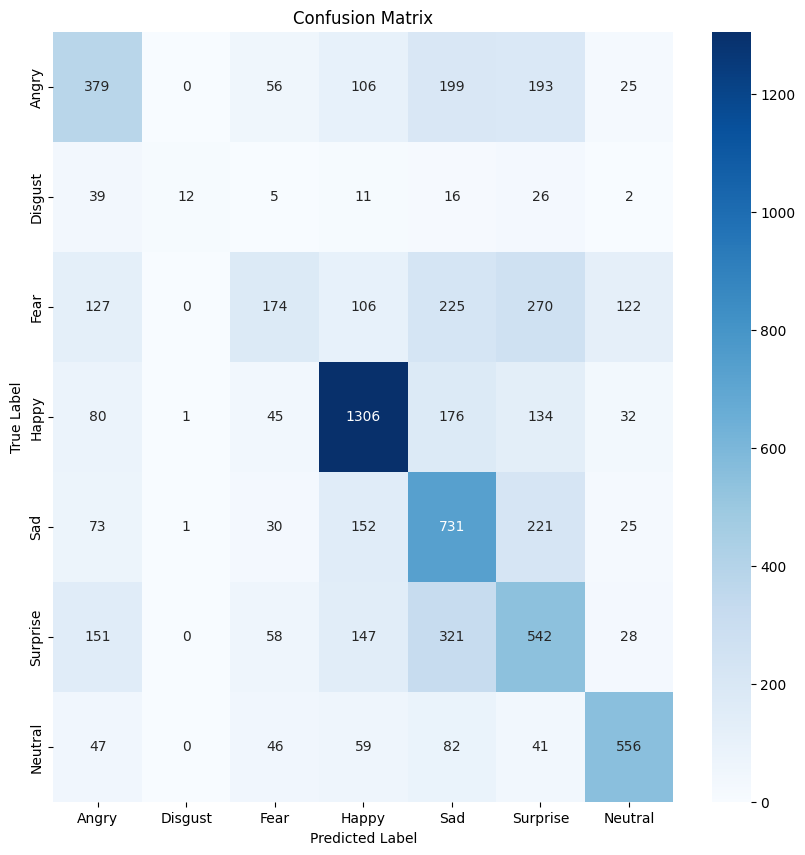

Epoch 2/20:
Train Loss: 5.0722 | Train Acc: 51.55%
Test Loss: 1.2542 | Test Acc: 51.55%


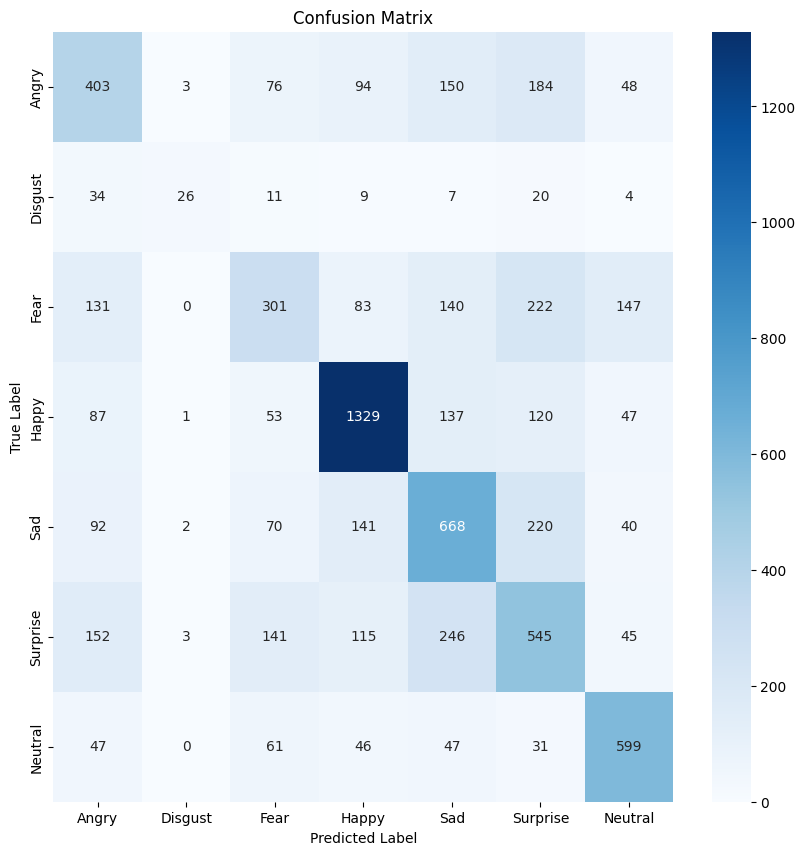

Epoch 3/20:
Train Loss: 4.4198 | Train Acc: 58.09%
Test Loss: 1.2153 | Test Acc: 53.93%


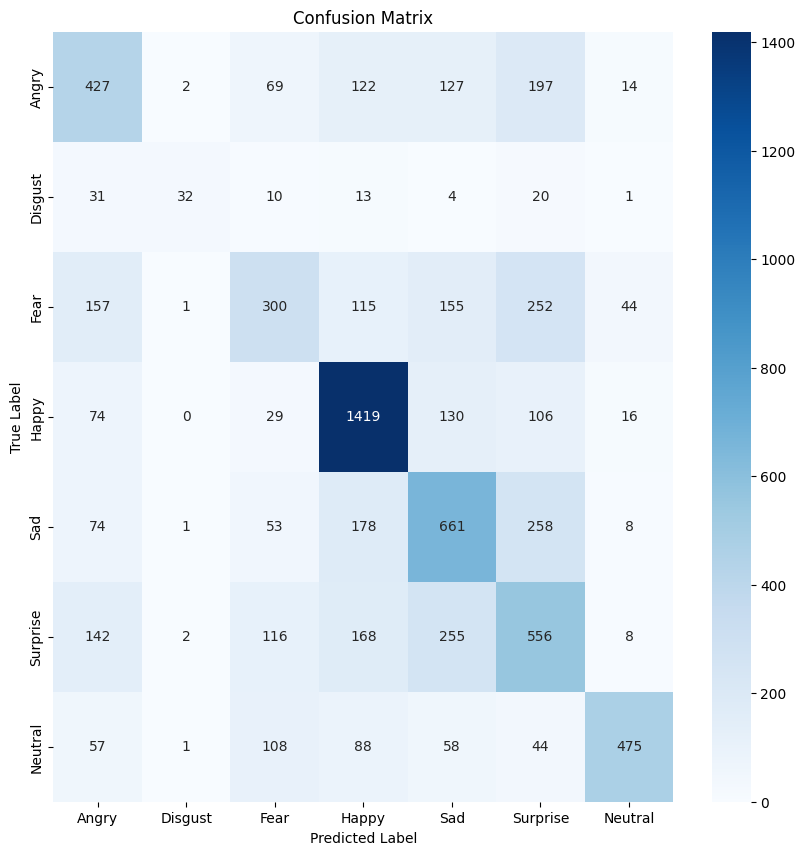

Epoch 4/20:
Train Loss: 3.8936 | Train Acc: 63.35%
Test Loss: 1.2175 | Test Acc: 53.91%


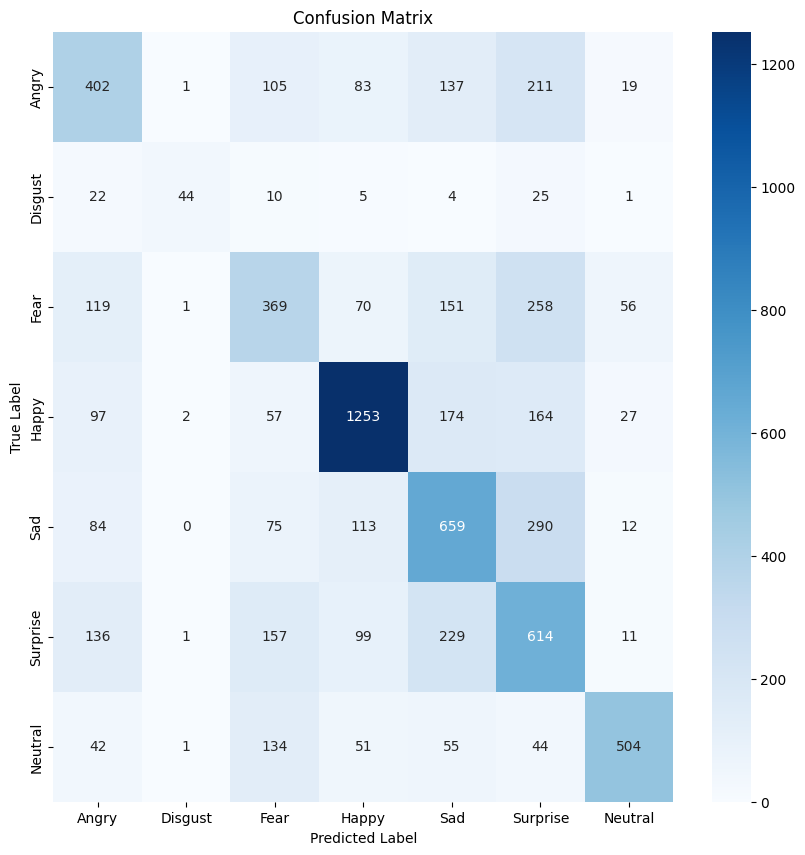

Epoch 5/20:
Train Loss: 3.3201 | Train Acc: 68.93%
Test Loss: 1.2433 | Test Acc: 53.57%


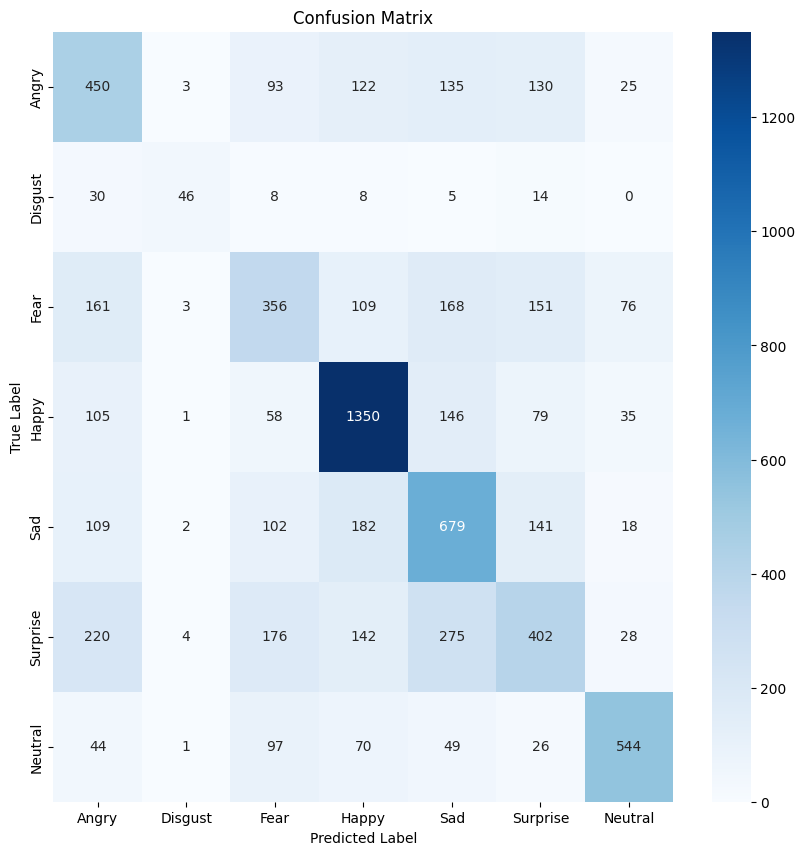

Epoch 6/20:
Train Loss: 2.7812 | Train Acc: 74.63%
Test Loss: 1.3257 | Test Acc: 53.32%


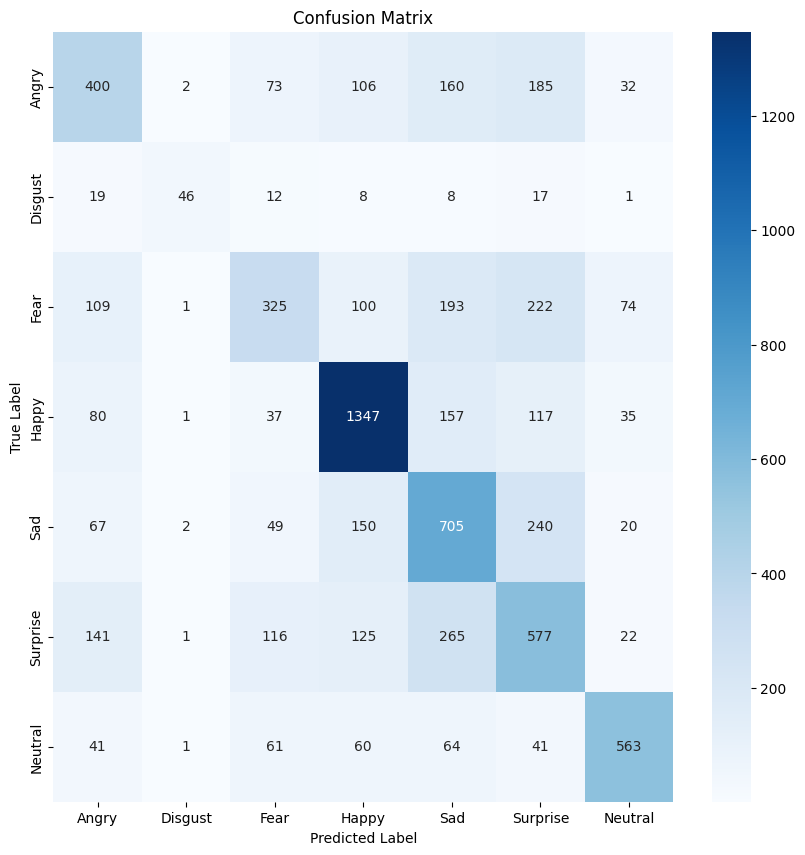

Epoch 7/20:
Train Loss: 2.4192 | Train Acc: 77.90%
Test Loss: 1.3513 | Test Acc: 55.21%


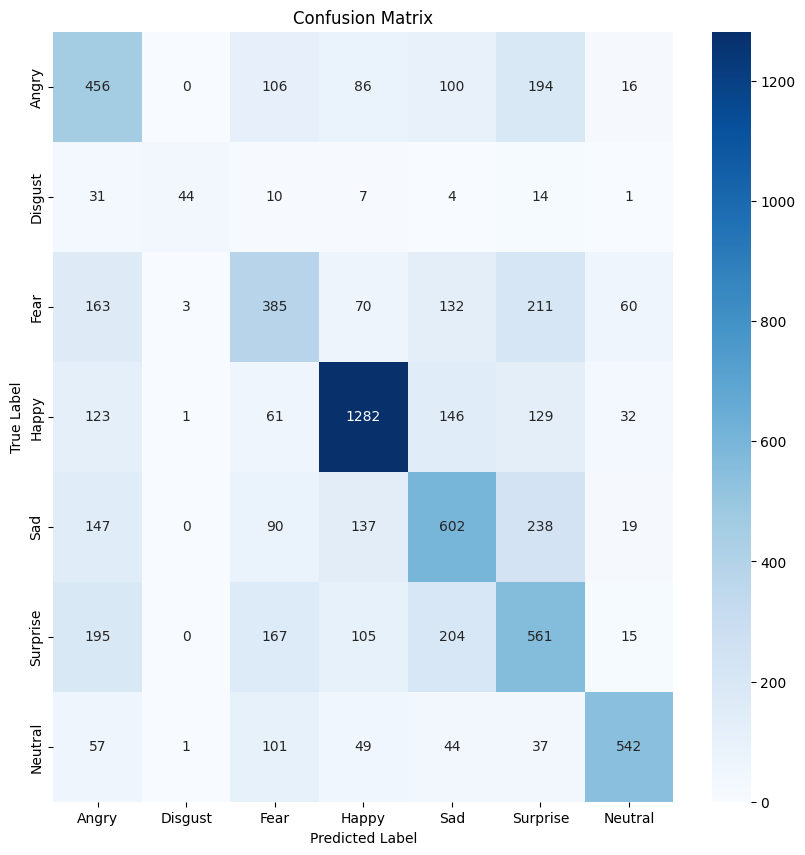

Epoch 8/20:
Train Loss: 1.8817 | Train Acc: 83.22%
Test Loss: 1.4082 | Test Acc: 53.94%


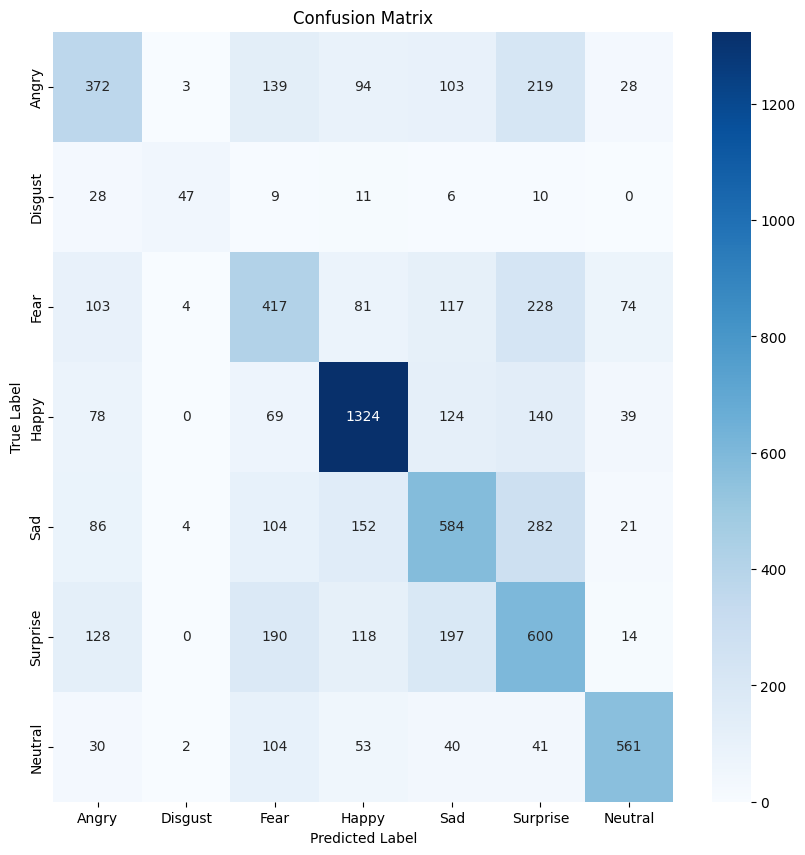

Epoch 9/20:
Train Loss: 1.5287 | Train Acc: 86.62%
Test Loss: 1.4824 | Test Acc: 54.40%


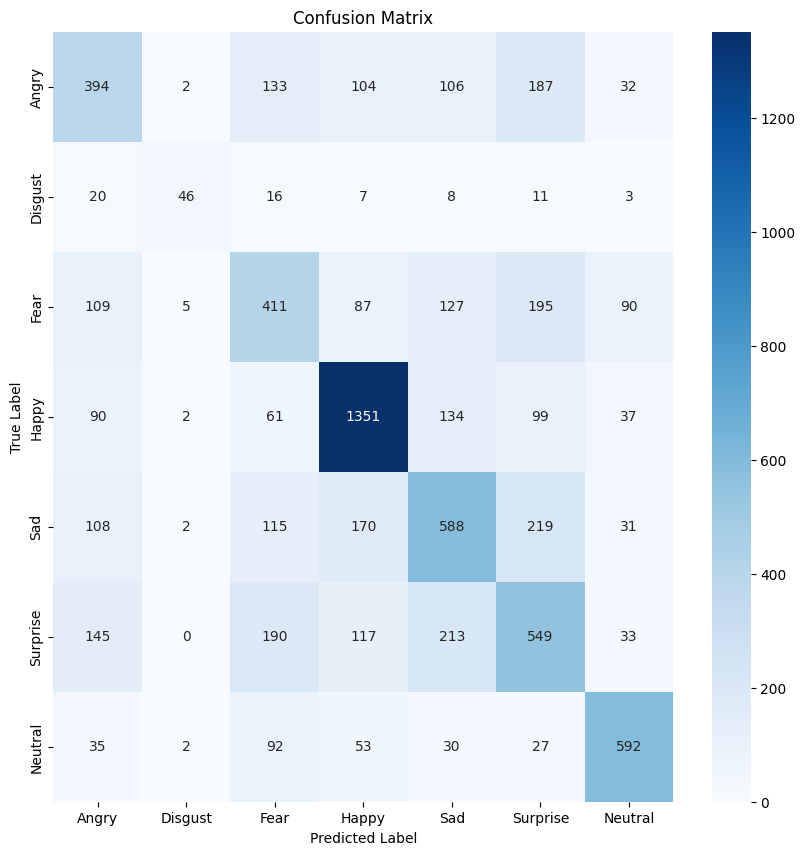

Epoch 10/20:
Train Loss: 1.3813 | Train Acc: 87.89%
Test Loss: 1.5553 | Test Acc: 54.76%


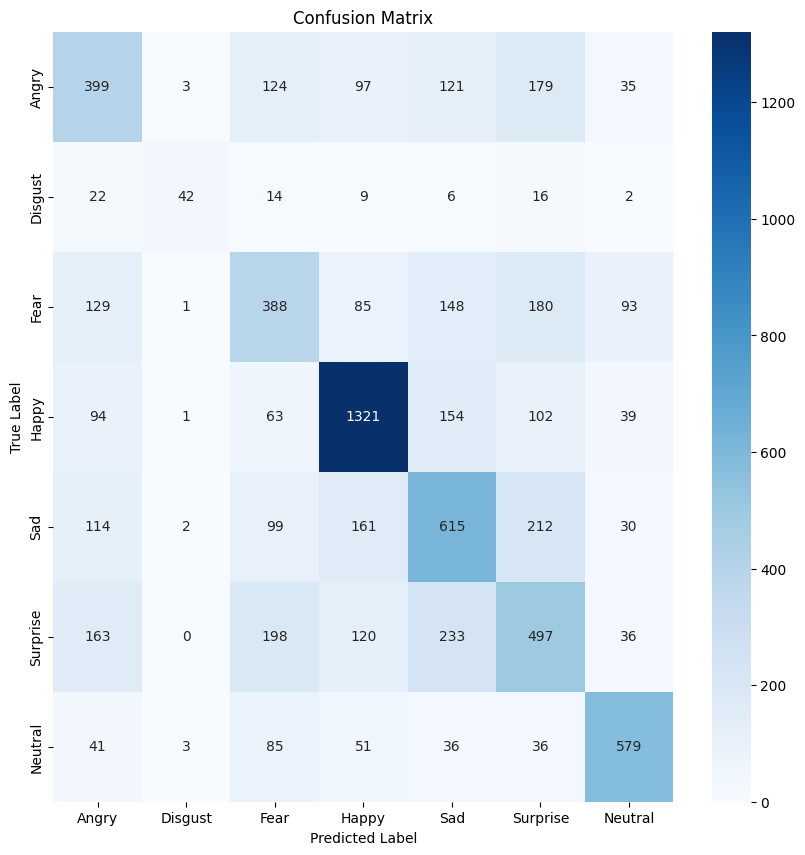

Epoch 11/20:
Train Loss: 1.1891 | Train Acc: 89.63%
Test Loss: 1.6398 | Test Acc: 53.51%


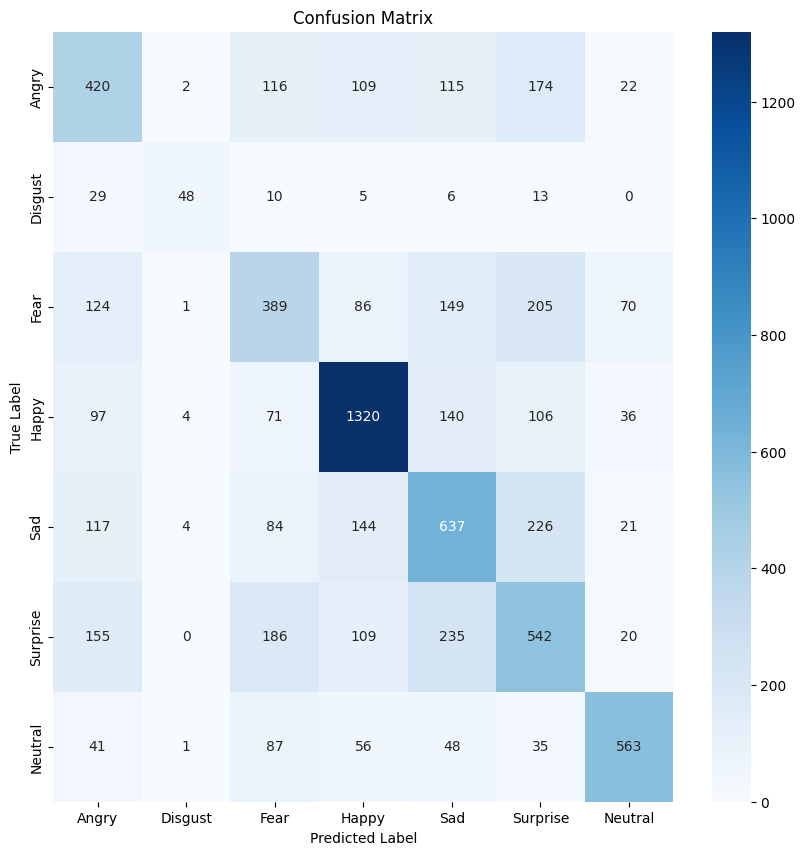

Epoch 12/20:
Train Loss: 1.1267 | Train Acc: 89.92%
Test Loss: 1.6513 | Test Acc: 54.60%


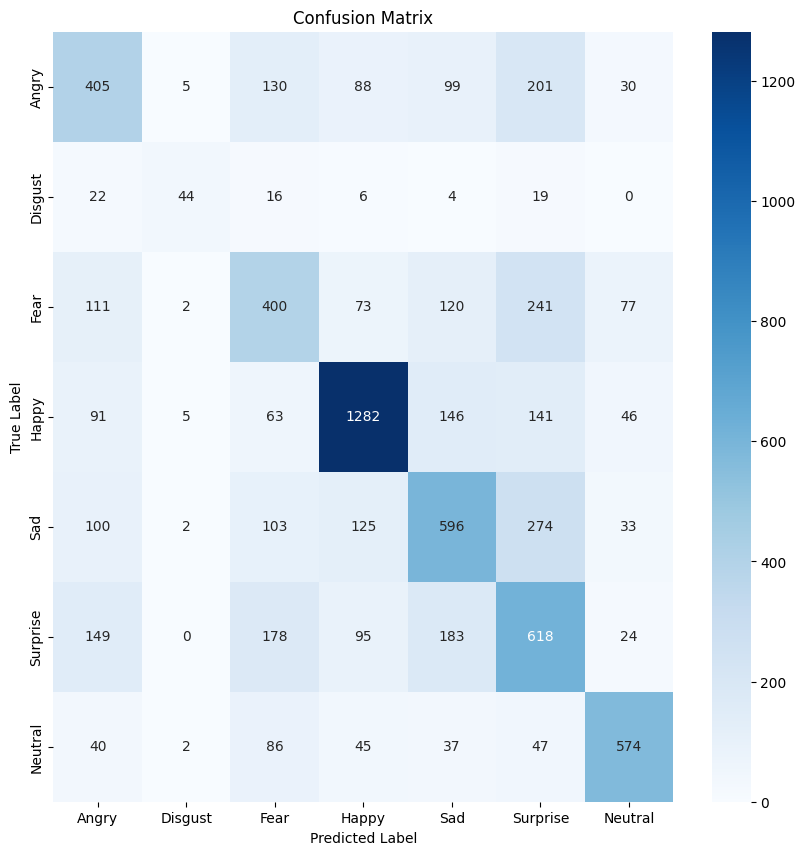

Epoch 13/20:
Train Loss: 0.8555 | Train Acc: 92.62%
Test Loss: 1.7536 | Test Acc: 54.60%


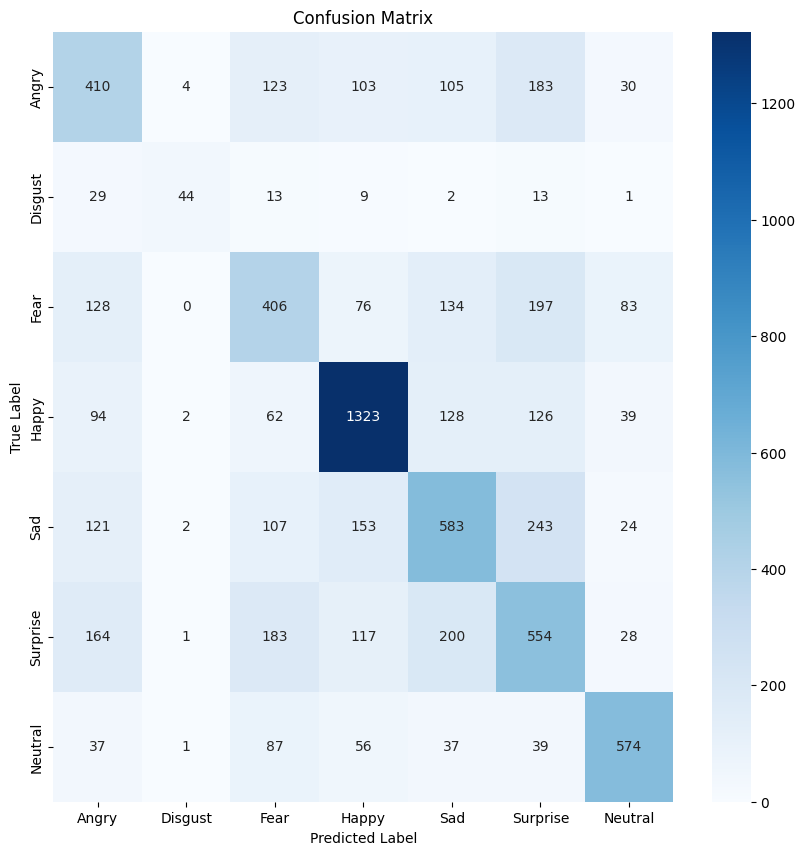

Epoch 14/20:
Train Loss: 0.7647 | Train Acc: 93.40%
Test Loss: 1.8042 | Test Acc: 54.25%


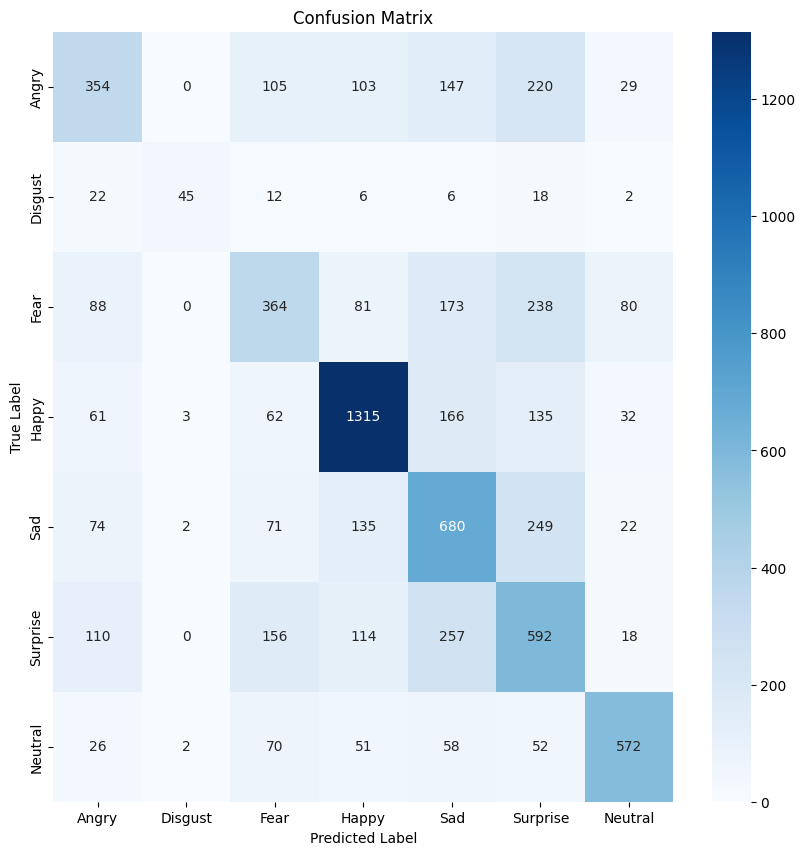

Epoch 15/20:
Train Loss: 0.6268 | Train Acc: 94.72%
Test Loss: 1.8464 | Test Acc: 54.64%


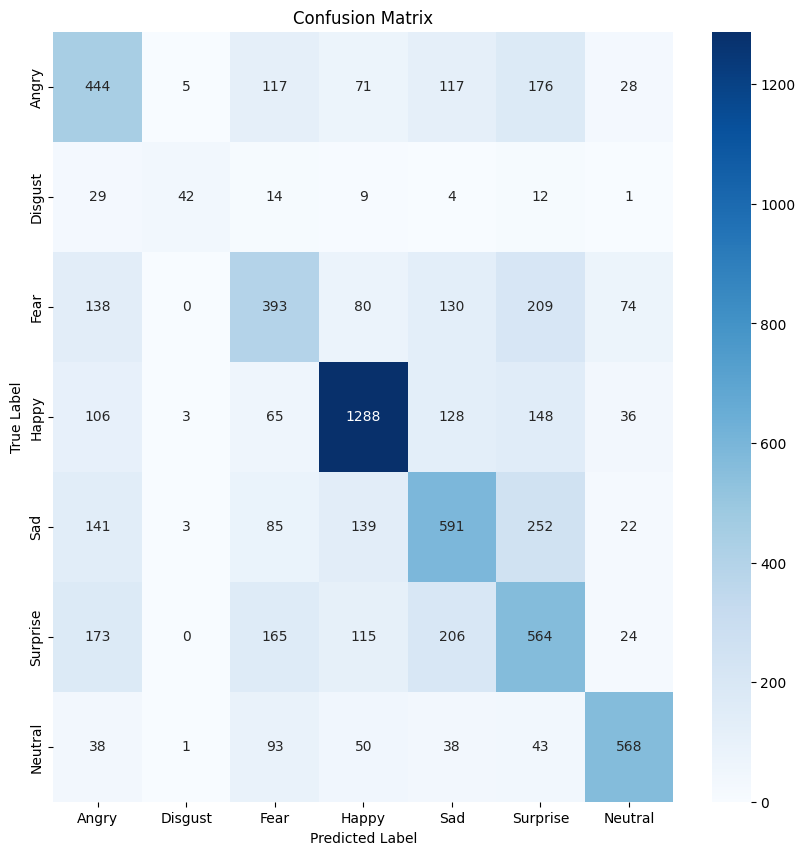

Epoch 16/20:
Train Loss: 0.6169 | Train Acc: 94.80%
Test Loss: 1.8968 | Test Acc: 54.19%


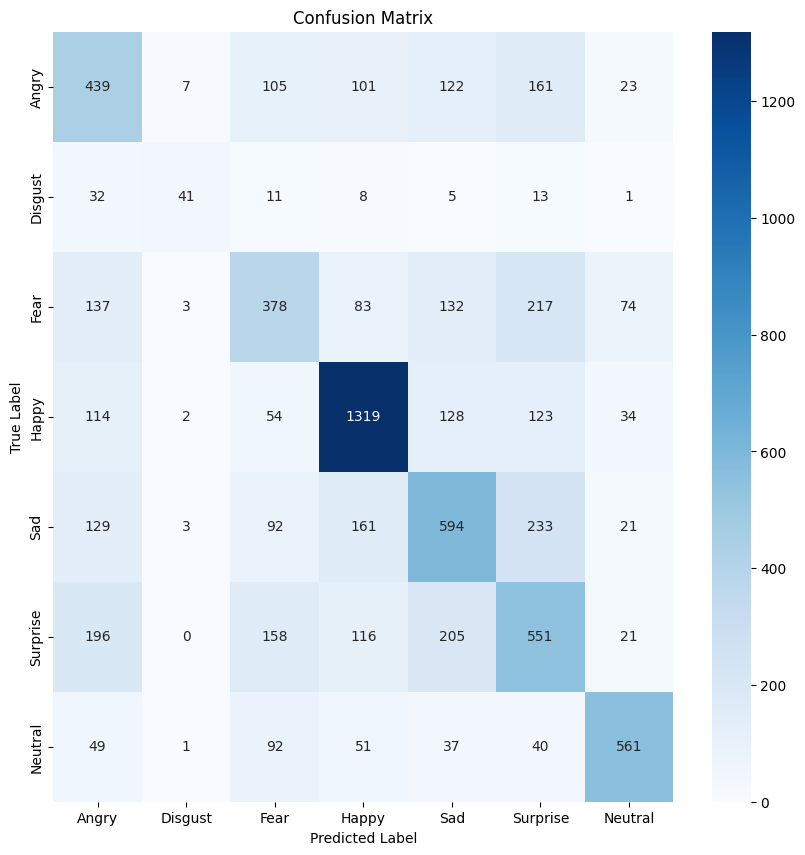

Epoch 17/20:
Train Loss: 0.5654 | Train Acc: 95.21%
Test Loss: 1.9623 | Test Acc: 54.10%


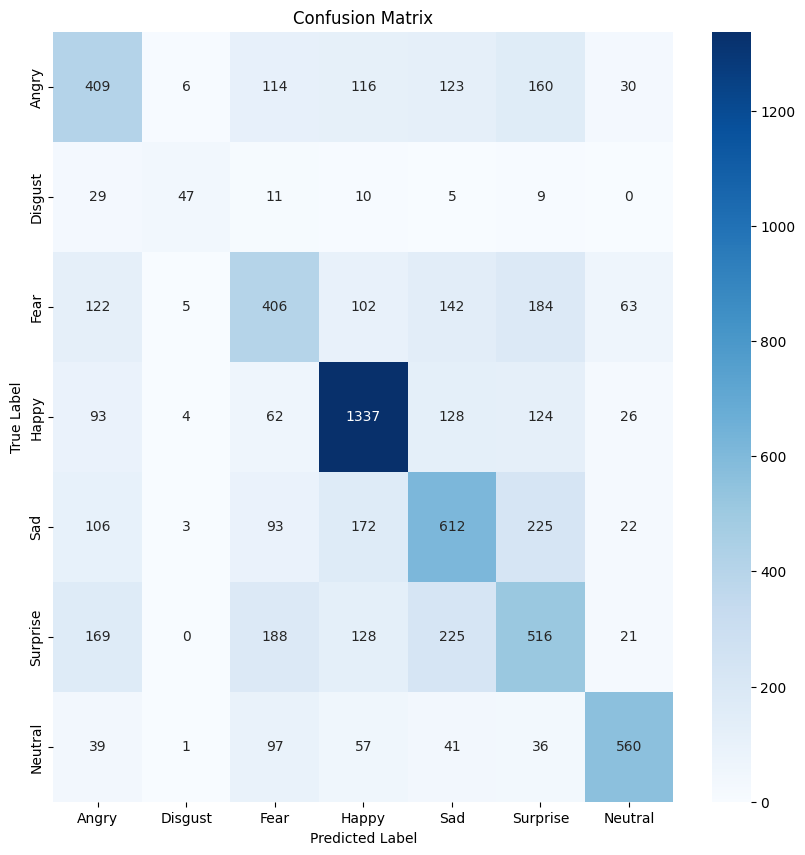

Epoch 18/20:
Train Loss: 0.5410 | Train Acc: 95.40%
Test Loss: 1.9919 | Test Acc: 54.15%


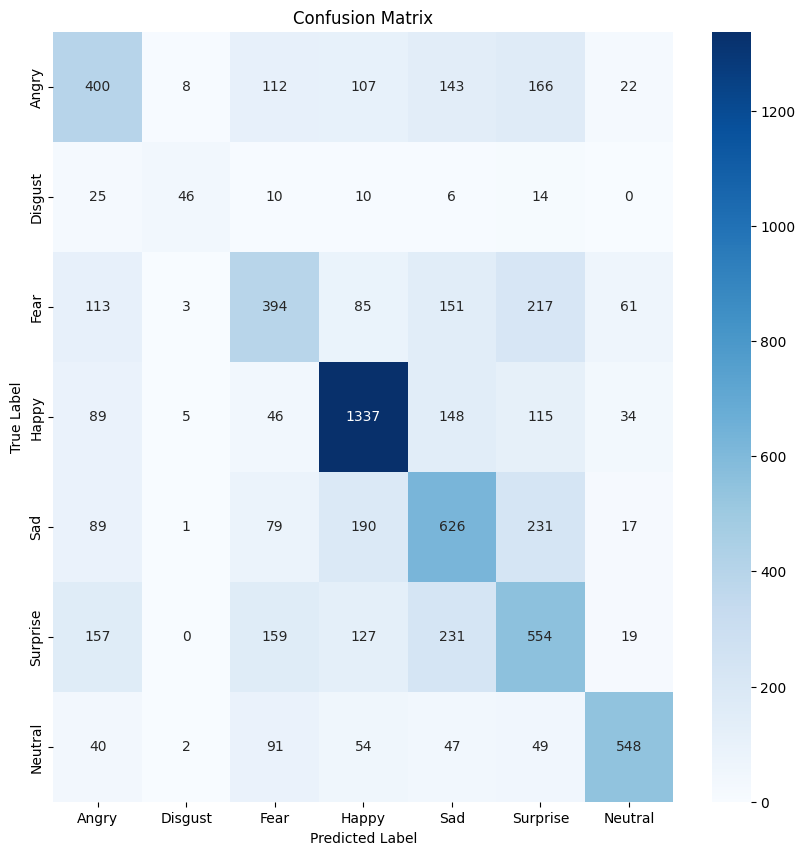

Epoch 19/20:
Train Loss: 0.4713 | Train Acc: 95.94%
Test Loss: 2.0829 | Test Acc: 54.40%


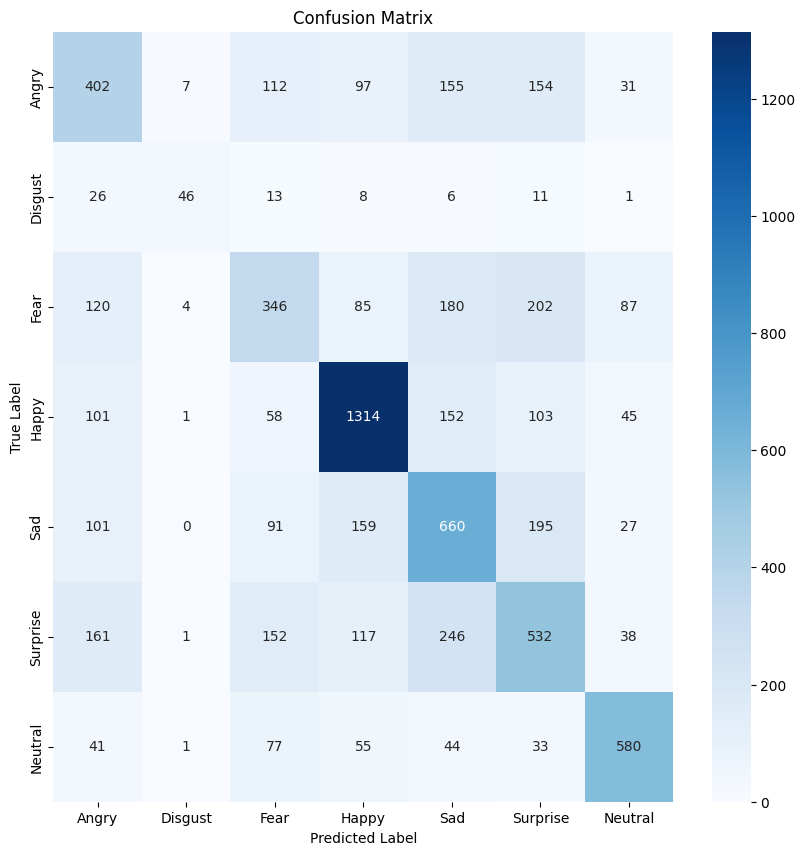

Epoch 20/20:
Train Loss: 0.5125 | Train Acc: 95.67%
Test Loss: 2.1043 | Test Acc: 54.05%


In [11]:
model = BaselineCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters())

train_accuracies = []
test_accuracies = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, DEVICE, train_loader, optimizer)
    test_loss, test_acc = test(model, DEVICE, test_loader, optimizer)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{EPOCHS}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%')